In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1KIvjqXZm6yp9HtyEqtrkt-pnEi-KLX9p

Defaulting to user installation because normal site-packages is not writeable
Downloading...
From (original): https://drive.google.com/uc?id=1KIvjqXZm6yp9HtyEqtrkt-pnEi-KLX9p
From (redirected): https://drive.google.com/uc?id=1KIvjqXZm6yp9HtyEqtrkt-pnEi-KLX9p&confirm=t&uuid=091f4ca0-89ae-487e-84d7-fdf1d69b5d0a
To: /home/hb/Documents/kaggle_compt/vjetch_submit/tiny_coco.zip
100%|████████████████████████████████████████| 594M/594M [00:07<00:00, 83.6MB/s]


In [2]:
!unzip tiny_coco.zip

Archive:  tiny_coco.zip
   creating: tiny_coco/
   creating: tiny_coco/train2017/
  inflating: tiny_coco/train2017/000000391895.jpg  
  inflating: tiny_coco/train2017/000000522418.jpg  
  inflating: tiny_coco/train2017/000000184613.jpg  
  inflating: tiny_coco/train2017/000000574769.jpg  
  inflating: tiny_coco/train2017/000000222564.jpg  
  inflating: tiny_coco/train2017/000000328757.jpg  
  inflating: tiny_coco/train2017/000000384213.jpg  
  inflating: tiny_coco/train2017/000000086408.jpg  
  inflating: tiny_coco/train2017/000000372938.jpg  
  inflating: tiny_coco/train2017/000000337264.jpg  
  inflating: tiny_coco/train2017/000000079841.jpg  
  inflating: tiny_coco/train2017/000000562150.jpg  
  inflating: tiny_coco/train2017/000000542145.jpg  
  inflating: tiny_coco/train2017/000000412151.jpg  
  inflating: tiny_coco/train2017/000000579003.jpg  
  inflating: tiny_coco/train2017/000000242611.jpg  
  inflating: tiny_coco/train2017/000000269105.jpg  
  inflating: tiny_coco/train2017/0

In [3]:
!rm tiny_coco.zip

# Part 1 : Obtain multi-class mask

In [4]:
!pip install pycocotools

Defaulting to user installation because normal site-packages is not writeable


In [14]:
from pycocotools.coco import COCO
import numpy as np
import cv2
import os
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

In [15]:
dataset_type = 'train2017' or 'val2017'
image_dir = f'tiny_coco/{dataset_type}'
ann_file = f'tiny_coco/annotations/instances_{dataset_type}.json'
output_mask_dir = f'masks_{dataset_type}'

In [7]:
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [8]:
from pycocotools import mask as maskUtils
flg = True
for i in range(2):
  os.makedirs(output_mask_dir, exist_ok=True)
  coco = COCO(ann_file)
  img_ids = coco.getImgIds()

  for img_id in tqdm(img_ids):
      img_info = coco.loadImgs(img_id)[0]
      img_name = img_info['file_name']
      width, height = img_info['width'], img_info['height']

      # Initialize empty mask
      mask = np.zeros((height, width), dtype=np.uint8)

      # Get annotations for this image
      ann_ids = coco.getAnnIds(imgIds=img_id)
      anns = coco.loadAnns(ann_ids)
      # print(anns[0]['segmentation'])

      for ann in anns:
          category_id = ann['category_id']
          seg = ann['segmentation']

          if ann['iscrowd']:
              rle = maskUtils.frPyObjects(seg, height, width)
              ann_mask = maskUtils.decode(rle)
          else:
              ann_mask = coco.annToMask(ann)
          # Add category_id to mask (multiclass)
          if ann_mask.ndim == 3:
              ann_mask = ann_mask[:, :, 0]

          mask[ann_mask == 1] = category_id
          if(flg):
            print(np.unique(mask))
            flg = False

      # Save mask
      mask_filename = img_name.replace('.jpg', '_mask.png')
      cv2.imwrite(os.path.join(output_mask_dir, mask_filename), mask)
  dataset_type = 'val2017'
  image_dir = f'tiny_coco/{dataset_type}'
  ann_file = f'tiny_coco/annotations/instances_{dataset_type}.json'
  output_mask_dir = f'masks_{dataset_type}'

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


  0%|          | 0/3000 [00:00<?, ?it/s]

[0 4]
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


  0%|          | 0/600 [00:00<?, ?it/s]

In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def colorize_mask(mask):
    # Map category IDs to distinct RGB colors
    unique_classes = np.unique(mask)
    # print("unique classes in mask  ",unique_classes)
    color_map = plt.cm.get_cmap('tab20', len(unique_classes))  # or use 'gist_ncar', 'hsv', etc.

    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i, cls in enumerate(unique_classes):
        if cls == 0: continue  # background
        colored_mask[mask == cls] = np.array(color_map(i)[:3]) * 255

    return colored_mask.astype(np.uint8)

In [26]:
import cv2
import numpy as np

/tmp/ipykernel_2651796/3575882168.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_classes))  # or use 'gist_ncar', 'hsv', etc.


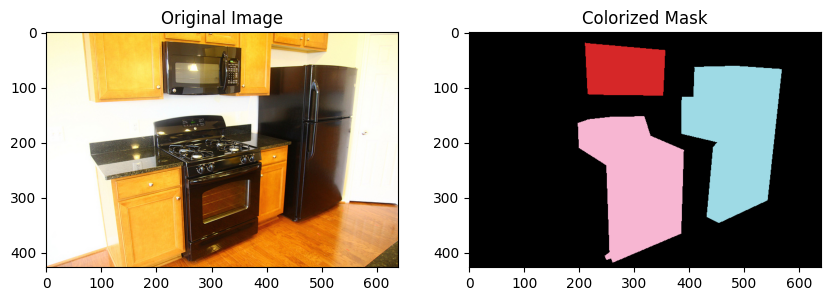

In [27]:
# Example
mask = cv2.imread("masks_train2017/000000086408_mask.png", 0)
colored = colorize_mask(mask)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread("tiny_coco/train2017/000000086408.jpg"), cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(colored)
plt.title("Colorized Mask")
plt.show()

In [11]:
# Paths
mask_dir = 'masks_train2017'
output_dir = 'colored_masks_train2017'
os.makedirs(output_dir, exist_ok=True)

In [15]:
for fname in tqdm(os.listdir(mask_dir)):
    if not fname.endswith('.png'):
        continue
    mask_path = os.path.join(mask_dir, fname)
    mask = cv2.imread(mask_path, 0)
    colored = colorize_mask(mask)

    save_path = os.path.join(output_dir, fname.replace('.png', '_colored.png'))
    cv2.imwrite(save_path, cv2.cvtColor(colored, cv2.COLOR_RGB2BGR))

  0%|          | 0/3000 [00:00<?, ?it/s]

/tmp/ipykernel_2650787/3575882168.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_classes))  # or use 'gist_ncar', 'hsv', etc.


In [16]:
# Validation data
mask_dir = 'masks_val2017'
output_dir = 'colored_masks_val2017'
os.makedirs(output_dir, exist_ok=True)

In [17]:
for fname in tqdm(os.listdir(mask_dir)):
    if not fname.endswith('.png'):
        continue
    mask_path = os.path.join(mask_dir, fname)
    mask = cv2.imread(mask_path, 0)
    colored = colorize_mask(mask)

    save_path = os.path.join(output_dir, fname.replace('.png', '_colored.png'))
    cv2.imwrite(save_path, cv2.cvtColor(colored, cv2.COLOR_RGB2BGR))

  0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_2650787/3575882168.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_classes))  # or use 'gist_ncar', 'hsv', etc.


# Part 2 : Train Image Segmentation

In [12]:
from torch.utils.data import Dataset
import cv2
import torch
import os
from PIL import Image
import torchvision.transforms as T

class CocoSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.transform = transform or T.Compose([
            T.Resize((256, 256)),
            # T.ToTensor()
        ])
        
        # Resize transform for masks (no normalization)
        self.mask_transform = T.Compose([
            T.Resize((256, 256), interpolation=Image.NEAREST)
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace(".jpg", "_mask.png"))

        # Load image with OpenCV
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask as grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Convert to PIL
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)

        # Apply transforms
        image = self.transform(image)
        mask = self.mask_transform(mask)

        # Convert to tensor
        image = T.ToTensor()(image)  # already normalized to [0,1]
        mask = torch.tensor(np.array(mask), dtype=torch.long)


        return image, mask


In [17]:
class DoubleConv(nn.Module):
    def __init__(self, in_channel, out_channel,kernel_size =3, stride = 1, padding = 1, bias = False):
        super(DoubleConv, self).__init__()
        self.conv2d = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, bias = bias),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channel, out_channel, kernel_size, stride, padding, bias = bias),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace = True)

        )
    def forward(self, x):
        return self.conv2d(x)    

class UNET(nn.Module):
    def __init__(self, out_channel =3, features = [64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        in_channel = 3
        for feature in features:
            self.downs.append(DoubleConv(in_channel, feature))
            in_channel = feature

        for feature in reversed(features):
            self.ups.append( 
                  nn.ConvTranspose2d(feature*2, feature, kernel_size = 2, stride = 2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], 2*features[-1]) 
        self.out_conv = nn.Conv2d(features[0], out_channel, kernel_size = 1)

    def forward(self, x):
            skip_connections = []
            for down in self.downs:
                x = down(x)
                skip_connections.append(x)
                x = self.pool(x)   

            x = self.bottleneck(x)

            for idx in range(0, len(self.ups), 2):
                x = self.ups[idx](x)
                skip = skip_connections.pop()    
                if x.shape != skip.shape:
                     x = TF.resize(x, size = skip.shape[2:])
                concat_skip = torch.cat((x, skip), dim = 1)
                x = self.ups[idx+1](concat_skip)

            return self.out_conv(x)          


In [18]:
# Metrics
def dice_score(preds, targets, smooth=1e-6):
    preds = torch.argmax(preds, dim=1)
    intersection = (preds == targets) & (targets > 0)
    dice = (2 * intersection.sum() + smooth) / (preds.sum() + targets.sum() + smooth)
    return dice.item()

def mean_iou(preds, targets, num_classes=91):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(1, num_classes):  # Skip background
        pred_cls = (preds == cls)
        target_cls = (targets == cls)
        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()
        if union > 0:
            ious.append((intersection / union).item())
    return sum(ious) / len(ious) if ious else 0.0


In [ ]:
# TRAINING CODE

from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from tqdm import tqdm
num_epochs=40

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_dataset = CocoSegmentationDataset("tiny_coco/train2017", "masks_train2017")
val_dataset   = CocoSegmentationDataset("tiny_coco/val2017",   "masks_val2017")

# for i in range(len(dataset)):
#     if dataset[0][0][0].shape[0] != dataset[0][1].shape[0]:
#        print("True")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)

model = UNET(out_channel=91).to(device)  # COCO has 91 classes (including background)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# stopper = EarlyStopper(patience=3)
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)
        # print("images shape",images.shape)
        # print("masks shape",masks.shape)

        preds = model(images)
        preds = F.interpolate(preds, size=masks.shape[1:], mode='bilinear', align_corners=False)
        loss = F.cross_entropy(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss / len(train_loader):.4f}")

    # 🔍 Validation step
    dice_total = 0
    iou_total = 0
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            preds = F.interpolate(preds, size=masks.shape[1:], mode='bilinear', align_corners=False)
            loss = F.cross_entropy(preds, masks)
            val_loss += loss.item()
            dice_total += dice_score(preds, masks)
            iou_total += mean_iou(preds, masks)

        val_loss /= len(val_loader)
        dice_avg = dice_total / len(val_loader)
        iou_avg = iou_total / len(val_loader)

    # if stopper(val_loss):
    #     print("⏹️ Early stopping triggered!")
    #     break
    if epoch == 15:
        torch.save(model.state_dict(), "model_epoch_15.pth")
    if epoch == 30:
        torch.save(model.state_dict(), "model_epoch_30.pth")
    print(f"Val Loss: {val_loss:.4f} | Dice: {dice_avg:.4f} | mIoU: {iou_avg:.4f}")
torch.save(model.state_dict(), "model_final.pth")

In [19]:
from collections import defaultdict

def per_class_iou(preds, targets, num_classes=91):
    preds = torch.argmax(preds, dim=1)
    ious = defaultdict(list)

    for cls in range(1, num_classes):  # Skip background
        pred_cls = (preds == cls)
        target_cls = (targets == cls)
        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()
        if union > 0:
            ious[cls].append((intersection / union).item())
    return {k: sum(v)/len(v) for k, v in ious.items()}

# Final per-class IoU
class_iou = defaultdict(list)

for images, masks in val_loader:
    images, masks = images.to(device), masks.to(device)
    preds = model(images)
    preds = F.interpolate(preds, size=masks.shape[1:], mode='bilinear', align_corners=False)
    cls_ious = per_class_iou(preds, masks)
    for cls_id, iou_val in cls_ious.items():
        class_iou[cls_id].append(iou_val)

# Final per-class IoU
for cls_id in sorted(class_iou):
    mean_cls_iou = sum(class_iou[cls_id]) / len(class_iou[cls_id])
    print(f"Class {cls_id} mIoU: {mean_cls_iou:.4f}")

NameError: name 'val_loader' is not defined

# Inference code

In [29]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- CONFIG ---
img_path = "tiny_coco/train2017/000000086408.jpg"
model_path = "model_final.pth"
input_size = (256, 256)
num_classes = 91
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load Model ---
model = UNET(out_channel=num_classes).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# --- Load Image ---
orig_img = cv2.imread(img_path)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(orig_img, input_size)
img_tensor = torch.tensor(resized_img / 255.0, dtype=torch.float).permute(2, 0, 1).unsqueeze(0).to(device)

# --- Predict ---
with torch.no_grad():
    pred = model(img_tensor)
    pred = F.interpolate(pred, size=orig_img.shape[:2], mode="bilinear", align_corners=False)
    pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()

# --- Colorize Output ---
def colorize_mask(mask):
    from matplotlib import cm
    unique_ids = sorted(np.unique(mask))
    colormap = (cm.get_cmap("tab20c", 256)(np.arange(256))[:, :3] * 255).astype(np.uint8)
    id_to_color = {cid: colormap[i % len(colormap)] for i, cid in enumerate(unique_ids)}

    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for cid in unique_ids:
        color_mask[mask == cid] = id_to_color[cid]
    return color_mask

print("unique classes in mask  ",np.unique(pred_mask))
print("pred_mask shape ",pred_mask.shape)
colored_pred = colorize_mask(pred_mask)

unique classes in mask   [ 0  7 67 72 73]
pred_mask shape  (427, 640)


/tmp/ipykernel_2651796/3408320689.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
/tmp/ipykernel_2651

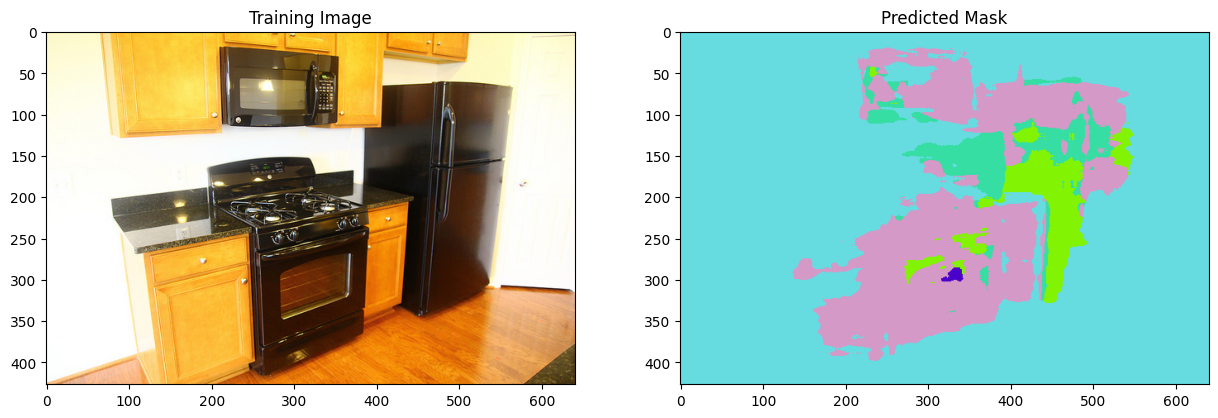

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Your original mask (2D numpy array of shape [427, 640], values from 0 to 90)
mask = np.array(pred_mask)  # replace with your mask variable if different

# Create a color map: 91 distinct colors for 91 classes
def get_colormap(num_classes=91):
    np.random.seed(42)  # to keep colors consistent
    return np.random.randint(0, 256, size=(num_classes, 3), dtype=np.uint8)

colormap = get_colormap()

# Map each class index in the mask to an RGB color
rgb_mask = colormap[mask]  # shape will be (427, 640, 3)

# If you want to visualize
# plt.imshow(rgb_mask)
# plt.axis('off')
# plt.title("RGB Mask Visualization")
# plt.show()
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1); plt.imshow(orig_img); plt.title("Training Image")
plt.subplot(1, 2, 2); plt.imshow(rgb_mask); plt.title("Predicted Mask")
plt.show()
# Or save it as an image
# Image.fromarray(rgb_mask).save("colored_mask.png")


In [31]:
# Save rgb mask
output_mask_path = "colored_mask.png"
Image.fromarray(rgb_mask).save(output_mask_path)

unique classes in mask   [ 0  1  4  6  7  8 13]
pred_mask shape  (500, 375)


/tmp/ipykernel_2651796/3791245828.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = (cm.get_cmap("tab20c", 256)(np.arange(256))[:, :3] * 255).astype(np.uint8)


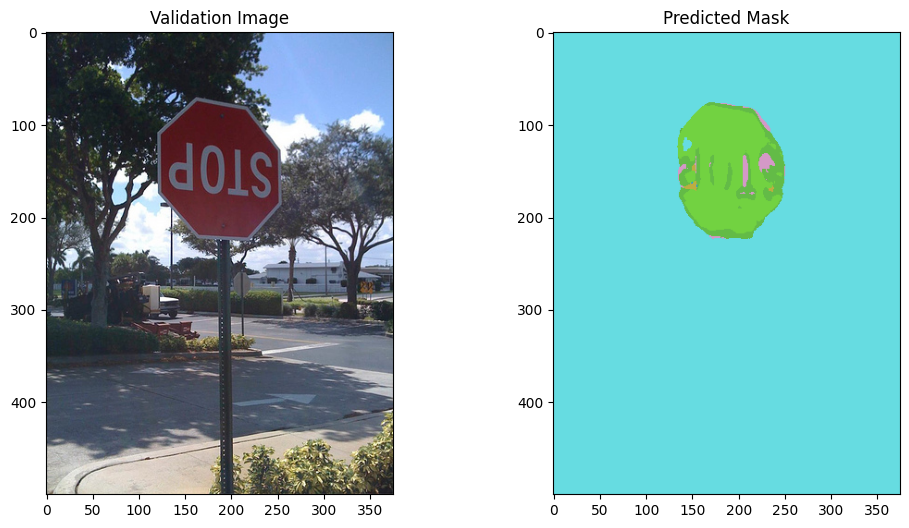

In [22]:
# Validation Image Inference

import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- CONFIG ---
img_path = "tiny_coco/val2017/000000000724.jpg"
model_path = "model_final.pth"
input_size = (256, 256)
num_classes = 91
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load Model ---
# model = UNet(num_classes=num_classes).to(device)
# model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# --- Load Image ---
orig_img = cv2.imread(img_path)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(orig_img, input_size)
img_tensor = torch.tensor(resized_img / 255.0, dtype=torch.float).permute(2, 0, 1).unsqueeze(0).to(device)

# --- Predict ---
with torch.no_grad():
    pred = model(img_tensor)
    pred = F.interpolate(pred, size=orig_img.shape[:2], mode="bilinear", align_corners=False)
    pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()

# --- Colorize Output ---
def colorize_mask(mask):
    from matplotlib import cm
    unique_ids = sorted(np.unique(mask))
    colormap = (cm.get_cmap("tab20c", 256)(np.arange(256))[:, :3] * 255).astype(np.uint8)
    id_to_color = {cid: colormap[i % len(colormap)] for i, cid in enumerate(unique_ids)}

    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for cid in unique_ids:
        color_mask[mask == cid] = id_to_color[cid]
    return color_mask

print("unique classes in mask  ",np.unique(pred_mask))
print("pred_mask shape ",pred_mask.shape)
colored_pred = colorize_mask(pred_mask)
# print("colored_pred shape ",colored_pred.shape)
# plt.imshow(colored_pred)
# # --- Overlay ---
# alpha = 0.5
# overlay = cv2.addWeighted(orig_img, 1 - alpha, colored_pred, alpha, 0)

# # --- Show Results ---
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1); plt.imshow(orig_img); plt.title("Original Image")
# plt.subplot(1, 3, 2); plt.imshow(colored_pred); plt.title("Predicted Mask")
# plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay")
# plt.axis("off")
# plt.tight_layout()
# plt.show()

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Your original mask (2D numpy array of shape [427, 640], values from 0 to 90)
mask = np.array(pred_mask)  # replace with your mask variable if different

# Create a color map: 91 distinct colors for 91 classes
def get_colormap(num_classes=91):
    np.random.seed(42)  # to keep colors consistent
    return np.random.randint(0, 256, size=(num_classes, 3), dtype=np.uint8)

colormap = get_colormap()

# Map each class index in the mask to an RGB color
rgb_mask = colormap[mask]  # shape will be (427, 640, 3)

# If you want to visualize
# plt.imshow(rgb_mask)
# plt.axis('off')
# plt.title("RGB Mask Visualization")
# plt.show()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1); plt.imshow(orig_img); plt.title("Validation Image")
plt.subplot(1, 2, 2); plt.imshow(rgb_mask); plt.title("Predicted Mask")
plt.show()
# Or save it as an image
# Image.fromarray(rgb_mask).save("colored_mask.png")
